### Importing Libraries

In [1]:
# sklearn optimization training
import sklearn
from sklearn.datasets import fetch_openml
mnist = fetch_openml(name='mnist_784')
mnist['data'] = mnist['data'].astype(float) /  255  # Normalized!

/Users/gauravg8/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
# keras model layers
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, BatchNormalization, Input, Dropout, UpSampling2D, Reshape, Flatten, Conv2DTranspose
from keras.layers import LeakyReLU

### Initializing Generator and Discriminator

In [3]:
# generator model
depth=200
dropout=.3
image_size = 28
half_image_size = 7
gan_layers = [
    Dense(depth*half_image_size*half_image_size, input_shape=(100,), kernel_initializer='glorot_normal'),
    BatchNormalization(momentum=0.9),
    Activation('relu'),
    Dropout(dropout),
    Reshape([half_image_size,half_image_size,depth]),
    Conv2DTranspose(depth/2, 5, strides=(2,2), padding='same', kernel_initializer='glorot_uniform'), # (14,14,128)
    BatchNormalization(momentum=0.9),
    Activation('relu'),
    Dropout(dropout), 
    Conv2DTranspose(depth/4, 3, strides=(2,2), padding='same', kernel_initializer='glorot_uniform'), # (28,28,64)
    BatchNormalization(momentum=0.9),
    Activation('relu'),
    Dropout(dropout), 
    Conv2DTranspose(depth/8, 3, padding='same', kernel_initializer='glorot_uniform'), # (28,28,32) 
    BatchNormalization(momentum=0.9),
    Activation('relu'),
    Dropout(dropout), 
    Conv2DTranspose(1, 3, padding='same'), # (28,28,1) 
    Activation('sigmoid')
]
gen = Sequential(layers=gan_layers)

In [4]:
# discriminator
leaky_alpha = .2
d_depth = 256
discriminator_layers = [
       Conv2D(d_depth, 5, strides=(2,2), input_shape=(image_size, image_size, 1), data_format='channels_last', padding='same'),
       LeakyReLU(alpha=leaky_alpha),
       Dropout(dropout),
       Conv2D(d_depth*2, 5, strides=(2,2), padding='same'),
       LeakyReLU(alpha=leaky_alpha),
       Dropout(dropout),
       Flatten(),
       Dense(256),
       LeakyReLU(alpha=leaky_alpha),
       Dropout(dropout),
       Dense(2),
       Activation('softmax')
]
dsc = Sequential(layers=discriminator_layers)

In [5]:
from keras import optimizers
opt = optimizers.Adam(lr=2e-4)
dopt = optimizers.Adam(lr=1e-4)

dsc.compile(optimizer=dopt, loss='categorical_crossentropy')

for layer in dsc.layers:
    layer.trainable = False

from keras.models import Model
adv_model = Sequential([gen,dsc])
adv_model.compile(optimizer=opt, loss='categorical_crossentropy')
adv_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         1586351   
                                                                 
 sequential_1 (Sequential)   (None, 2)                 9707266   
                                                                 
Total params: 11293617 (43.08 MB)
Trainable params: 1566401 (5.98 MB)
Non-trainable params: 9727216 (37.11 MB)
_________________________________________________________________


### Pretraining of Discriminator

313/313 [==============================] - 4s 12ms/step


Text(0.5, 1.0, 'Fake Image')

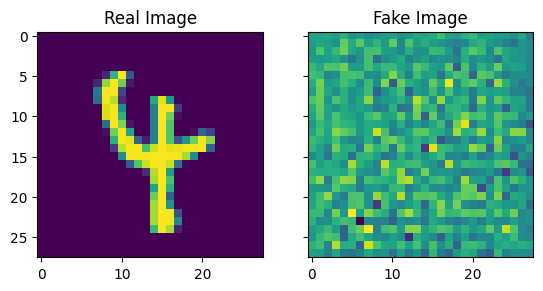

In [6]:
# prior distribution
generate_values = lambda x : np.random.uniform(-1,1, size=(x,100))

# Initial Discriminator Training
import numpy as np
initial_training_size = 10000
real_images = mnist['data'].values[np.random.choice(len(mnist['data']), size=initial_training_size)].reshape(initial_training_size,image_size, image_size,1)  # need the .values to index by row instead of column
fake_images = gen.predict(generate_values(initial_training_size))

%matplotlib inline
import matplotlib.pyplot as plt
f, axs =plt.subplots(1,2, sharey=True)
axs[0].imshow(real_images[1,:,:,0])
axs[1].imshow(fake_images[1,:,:,0])
axs[0].set_title('Real Image')
axs[1].set_title('Fake Image')

In [7]:
# Compile initial training set
X = np.concatenate([real_images, fake_images])
y = np.zeros((2*initial_training_size,2))
y[:initial_training_size,1] = 1
y[initial_training_size:,0] = 1
dsc.fit(X,y, batch_size=32, epochs=1)

625/625 [==============================] - 72s 115ms/step - loss: 0.0095


### Combined Training 1

In [8]:
half_mini_batch_size = 32  # moderate mini_batch_size testing

steps = 10000
y = np.zeros(shape=(2*half_mini_batch_size,2))
y[:int(half_mini_batch_size), 1]=1
y[int(half_mini_batch_size):, 0]=1

d_loss = np.zeros(steps)
a_loss = np.zeros(steps)

for k in range(steps):
    if k % 50 == 0:
        print(k)
        
    X = np.concatenate([ 
        mnist['data'].values[np.random.choice(len(mnist['data']), size=half_mini_batch_size)].reshape(half_mini_batch_size,image_size, image_size,1),
        gen.predict(generate_values(half_mini_batch_size))  # think about training separately??
    ])
    d_loss[k] = dsc.train_on_batch(X,y)
    
    # Train GAN
    X_adv = generate_values(2*half_mini_batch_size)
    y_adv = np.zeros((2*half_mini_batch_size, 2))
    y_adv[:, 1] = 1
    a_loss[k] = adv_model.train_on_batch(X_adv, y_adv)

0
1/1 [==============================] - 0s 21ms/step
50
1/1 [==============================] - 0s 22ms/step
100
1/1 [==============================] - 0s 22ms/step
150
1/1 [==============================] - 0s 24ms/step
200
1/1 [==============================] - 0s 21ms/step
250
1/1 [==============================] - 0s 23ms/step
300
1/1 [==============================] - 0s 25ms/step
350
1/1 [==============================] - 0s 21ms/step
400
1/1 [==============================] - 0s 20ms/step
450
1/1 [==============================] - 0s 21ms/step
500
1/1 [==============================] - 0s 21ms/step
550
1/1 [==============================] - 0s 20ms/step
600
1/1 [==============================] - 0s 21ms/step
650
1/1 [==============================] - 0s 22ms/step
700
1/1 [==============================] - 0s 21ms/step
750
1/1 [==============================] - 0s 20ms/step
800
1/1 [==============================] - 0s 21ms/step
850
1/1 [==============================] - 0s 21ms/

### Display Results 1

NameError: name 'real_images' is not defined

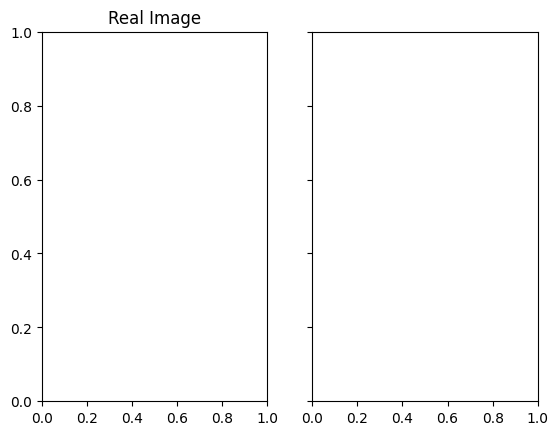

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
f, axs =plt.subplots(1,2, sharey=True)
axs[0].set_title('Real Image')
axs[0].imshow(real_images[1,:,:,0])
axs[1].set_title('Fake Image')
axs[1].imshow(gen.predict(generate_values(1))[0,:,:,0])

1/1 [==============================] - 0s 9ms/step


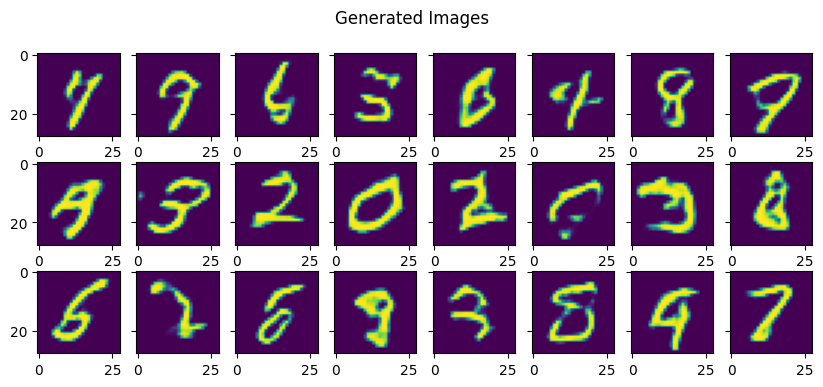

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
f, axs =plt.subplots(3,8, sharey=True, figsize=(10,4))
plt.suptitle('Generated Images')
for j in range(3):
    for k in range(8):
        axs[j][k].imshow(gen.predict(generate_values(1))[0,:,:,0])

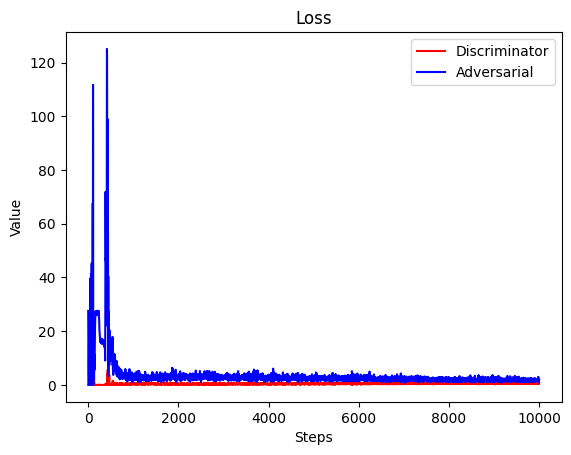

In [11]:
plt.plot(d_loss, color='r')
plt.plot(a_loss, color='b')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.title('Loss')
plt.legend(['Discriminator','Adversarial'])